In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

import numpy as np
import sys
sys.path.append("..")
import pprint

from collections import defaultdict

from reference.lib.envs.blackjack import BlackjackEnv
from reference.lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [85]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum   = defaultdict(float)
    returns_count = defaultdict(float)

    # The final value function
    V = defaultdict(float)
    
    # start the loop
    for _ in range(num_episodes):
        
        list_of_state_in_eps = []
        list_of_reward_ineps = []
        
        observation    = env.reset()
        list_of_state_in_eps.append(observation)
        action_to_take = sample_policy(observation)
        next_observation,reward,game_over,_ = env.step(action_to_take)
        list_of_reward_ineps.append(reward)
        observation    = next_observation
        
        while not game_over: 
            list_of_state_in_eps.append(observation)
            action_to_take = sample_policy(observation)
            next_observation,reward,game_over,_ = env.step(action_to_take)
            list_of_reward_ineps.append(reward)
            observation    = next_observation
            
            if not game_over:
                list_of_state_in_eps.append(observation)
                list_of_reward_ineps.append(reward)
            
        # loop over each state and reward 
        for index in range(len(list_of_state_in_eps)):
            returns_count[list_of_state_in_eps[index]] = returns_count[list_of_state_in_eps[index]] + 1 if list_of_state_in_eps[index] in returns_count else 1
            returns_sum[list_of_state_in_eps[index]]   = returns_sum[list_of_state_in_eps[index]]   + sum(list_of_reward_ineps[index:]) if list_of_state_in_eps[index] in returns_sum else sum(list_of_reward_ineps[index:])
        
    for xx in returns_sum.keys():
        V[xx] = returns_sum[xx]/returns_count[xx]

    return V    

def mc_prediction_inc(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum   = defaultdict(float)
    returns_count = defaultdict(float)

    # The final value function
    V = defaultdict(float)
    
    # start the loop
    for _ in range(num_episodes):
        
        list_of_state_in_eps = []
        list_of_reward_ineps = []
        
        observation    = env.reset()
        list_of_state_in_eps.append(observation)
        action_to_take = sample_policy(observation)
        next_observation,reward,game_over,_ = env.step(action_to_take)
        list_of_reward_ineps.append(reward)
        observation    = next_observation
        
        while not game_over: 
            list_of_state_in_eps.append(observation)
            action_to_take = sample_policy(observation)
            next_observation,reward,game_over,_ = env.step(action_to_take)
            list_of_reward_ineps.append(reward)
            observation    = next_observation
            
            if not game_over:
                list_of_state_in_eps.append(observation)
                list_of_reward_ineps.append(reward)
            
        # loop over each state and reward 
        for index in range(len(list_of_state_in_eps)):
            returns_count[list_of_state_in_eps[index]] = returns_count[list_of_state_in_eps[index]] + 1 if list_of_state_in_eps[index] in returns_count else 1
            
            if list_of_state_in_eps[index] in V:
                V[list_of_state_in_eps[index]] = V[list_of_state_in_eps[index]] + (sum(list_of_reward_ineps[index:]) - V[list_of_state_in_eps[index]])/returns_count[list_of_state_in_eps[index]]
            else:
                V[list_of_state_in_eps[index]] = (sum(list_of_reward_ineps[index:]))/returns_count[list_of_state_in_eps[index]]
        
    return V    

def mc_prediction_inc_online(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    step_size = discount_factor

    # The final value function
    V = defaultdict(float)
    
    # start the loop
    for _ in range(num_episodes):
        
        observation    = env.reset()
        V[observation] = 0
        action_to_take = sample_policy(observation)
        next_observation,reward,game_over,_ = env.step(action_to_take)
        V[observation] = V[observation] + step_size*(reward - V[observation])
        observation    = next_observation
        
        while not game_over: 
            V[observation] = 0 if not observation in V else V[observation]                           
            action_to_take = sample_policy(observation)
            next_observation,reward,game_over,_ = env.step(action_to_take)
            V[observation] = V[observation] + step_size*(reward - V[observation])
            observation    = next_observation
            
            if not game_over:
                V[observation] = V[observation] + step_size*(reward - V[observation])
            
    return V  

def TD_zero(policy, env, num_episodes, discount_factor=1.0):

    step_size = discount_factor

    # The final value function
    V = defaultdict(float)
    
    # start the loop
    for _ in range(num_episodes):
        
        observation    = env.reset()
        V[observation] = 0
        action_to_take = sample_policy(observation)
        next_observation,reward,game_over,_ = env.step(action_to_take)
        
        V[next_observation] = 0 if not next_observation in V else V[next_observation] 
        V[observation] = V[observation] + step_size*(reward +step_size*V[next_observation] - V[observation])
        observation    = next_observation
        
        while not game_over: 
            V[observation] = 0 if not observation in V else V[observation]                           
            action_to_take = sample_policy(observation)
            next_observation,reward,game_over,_ = env.step(action_to_take)
            V[next_observation] = 0 if not next_observation in V else V[next_observation] 
            V[observation] = V[observation] + step_size*(reward +step_size*V[next_observation] - V[observation])
            observation    = next_observation
            
    return V  

def TD_one(policy, env, num_episodes, discount_factor=1.0):

    step_size = discount_factor

    # The final value function
    V = defaultdict(float)
    
    # start the loop
    for _ in range(num_episodes):
        
        observation    = env.reset()
        
        two_rwd_list   = []
        two_eps_list   = []
        V[observation] = 0 if not observation in V else V[observation] 
        
        for _ in range(3):
            two_eps_list.append(observation)
            action_to_take = sample_policy(observation)
            next_observation,reward,game_over,_ = env.step(action_to_take)
            two_rwd_list.append(reward)
            observation    = next_observation
            if game_over: break
                
        V[two_eps_list[-1]] = 0 if not two_eps_list[-1] in V else V[two_eps_list[-1]] 
        two_rwd_list = two_rwd_list[:2]
        V[two_eps_list[0]]  = V[two_eps_list[0]] + step_size*(sum(step_size**index * element for index,element in enumerate(two_rwd_list))+(step_size**2)*V[two_eps_list[-1]] - V[two_eps_list[0]])
        #sdsa
        observation   = two_eps_list[:2][-1]
        
        while not game_over: 
            two_rwd_list   = []
            two_eps_list   = []
            V[observation] = 0 if not observation in V else V[observation] 

            for _ in range(3):
                two_eps_list.append(observation)
                action_to_take = sample_policy(observation)
                next_observation,reward,game_over,_ = env.step(action_to_take)
                two_rwd_list.append(reward)
                observation    = next_observation
                if game_over: break

            V[two_eps_list[-1]] = 0 if not two_eps_list[-1] in V else V[two_eps_list[-1]] 
            two_rwd_list = two_rwd_list[:2]
            V[two_eps_list[0]]  = V[two_eps_list[0]] + step_size*(sum(step_size**index * element for index,element in enumerate(two_rwd_list))+(step_size**2)*V[two_eps_list[-1]] - V[two_eps_list[0]])
            observation    = two_eps_list[:2][-1]

    return V  

In [86]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

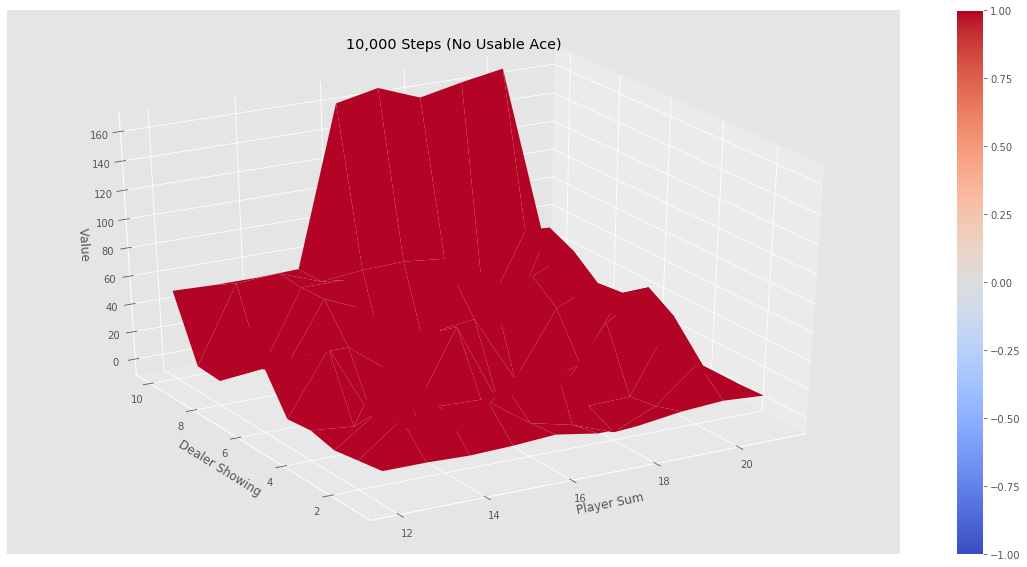

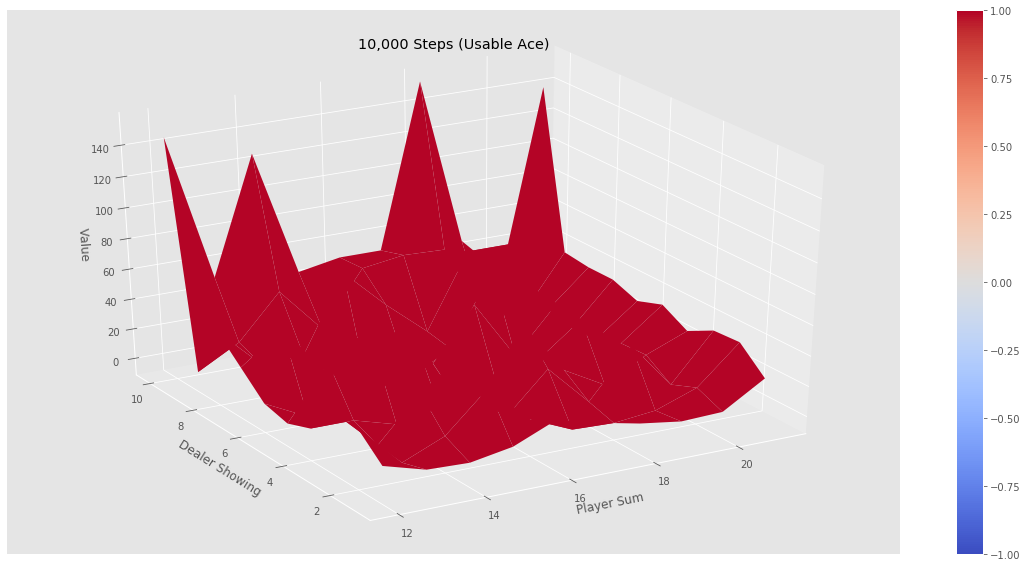

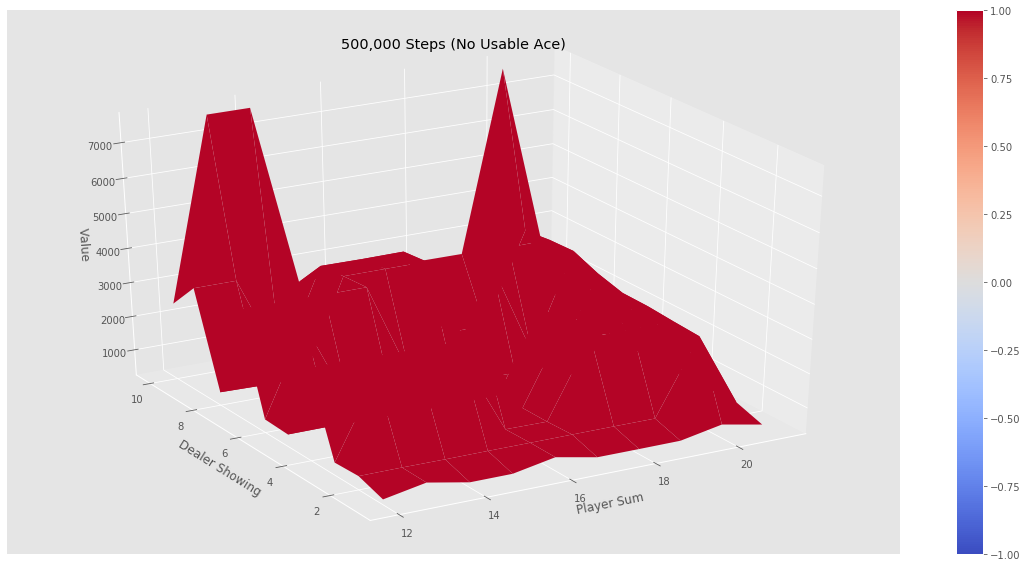

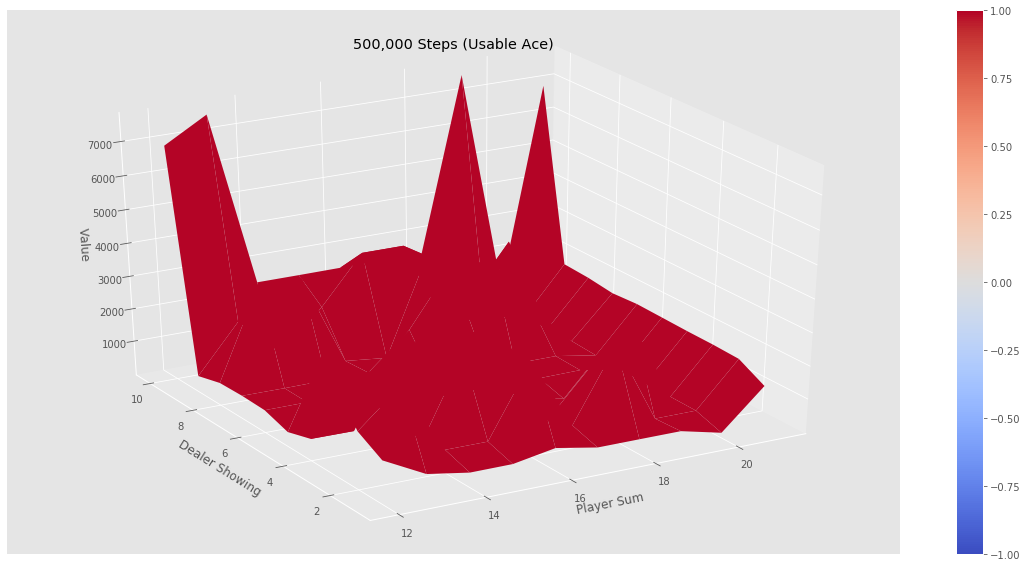

In [87]:
V_10k = TD_one(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

V_500k = TD_one(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")

In [69]:
temp=[1]
temp=temp[:2]
print(temp)
for index, element in enumerate(temp):
    print(index,element)
vaa = 0.9
print(sum(element+vaa**index for index,element in enumerate(temp)))

[1]
0 1
2.0


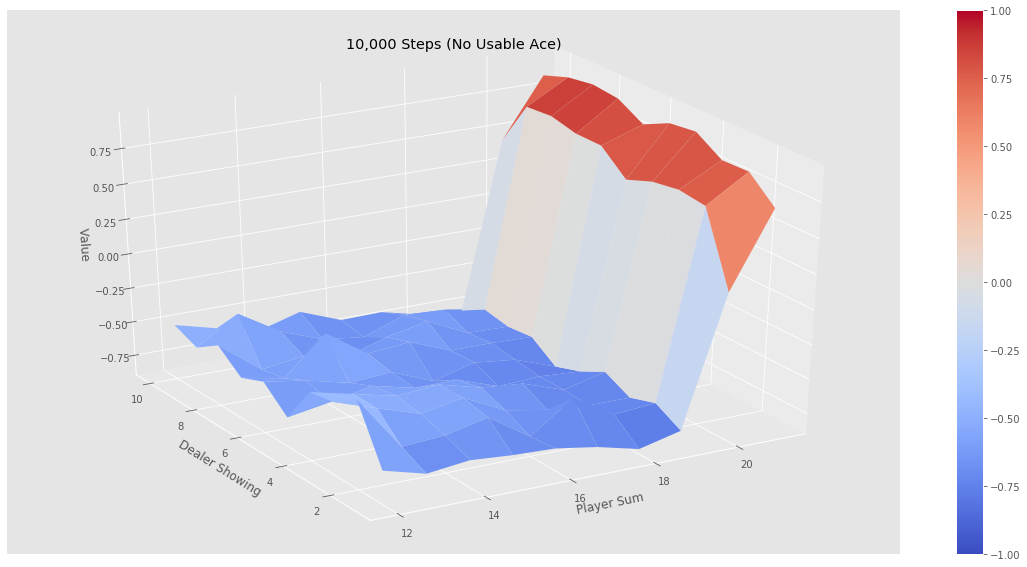

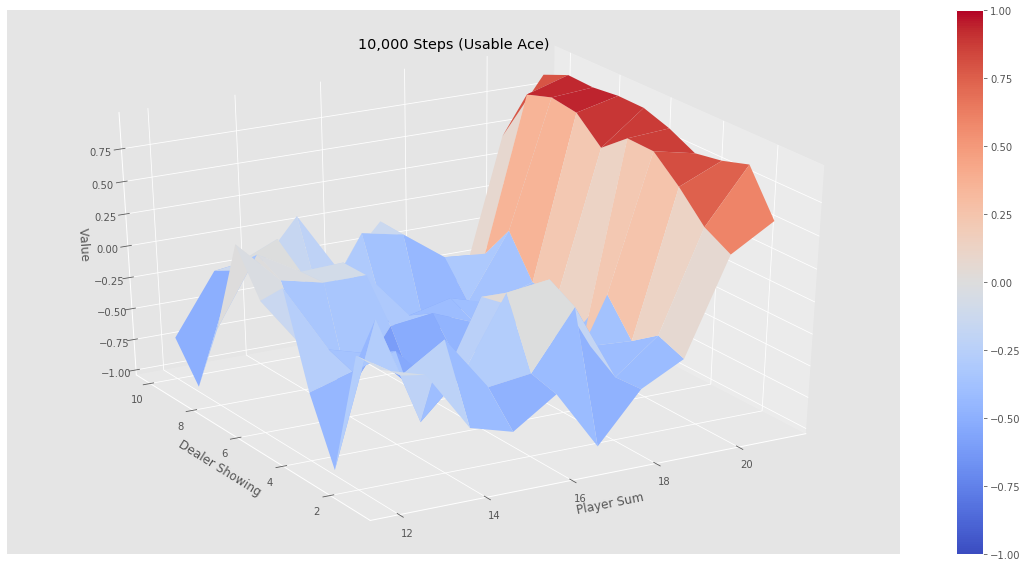

KeyboardInterrupt: 

In [6]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")

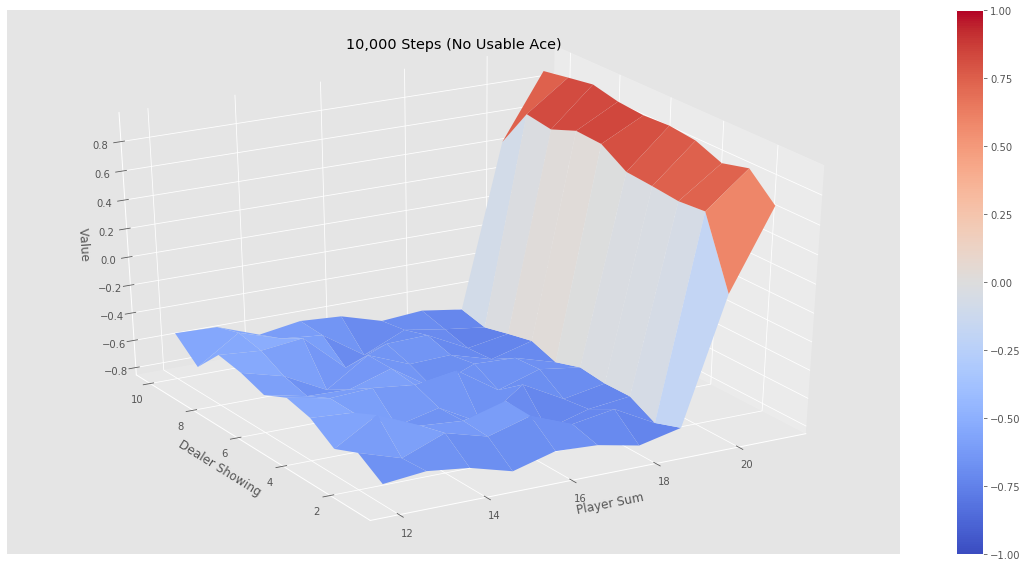

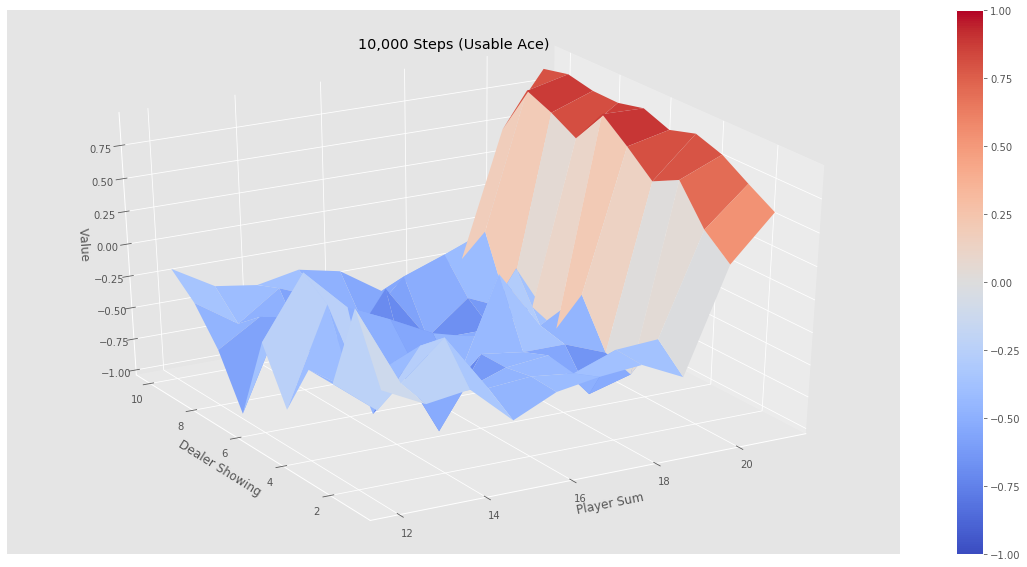

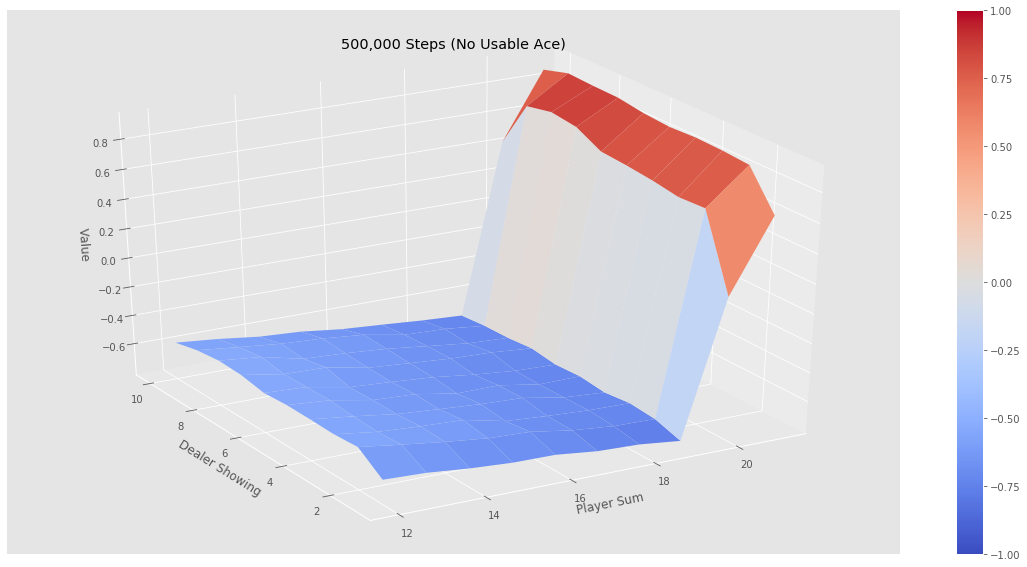

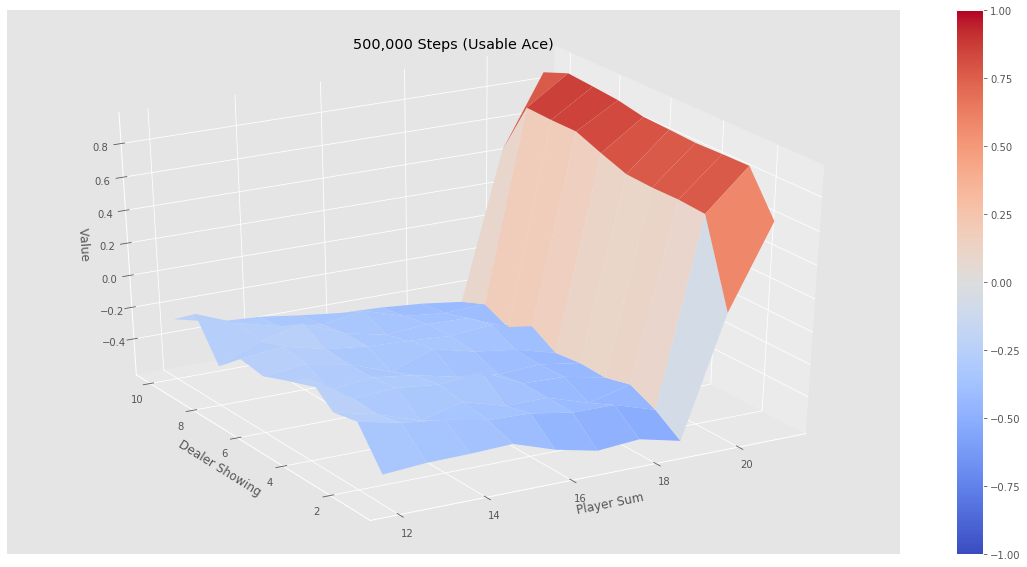

In [181]:
V_10k = mc_prediction_inc(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction_inc(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")

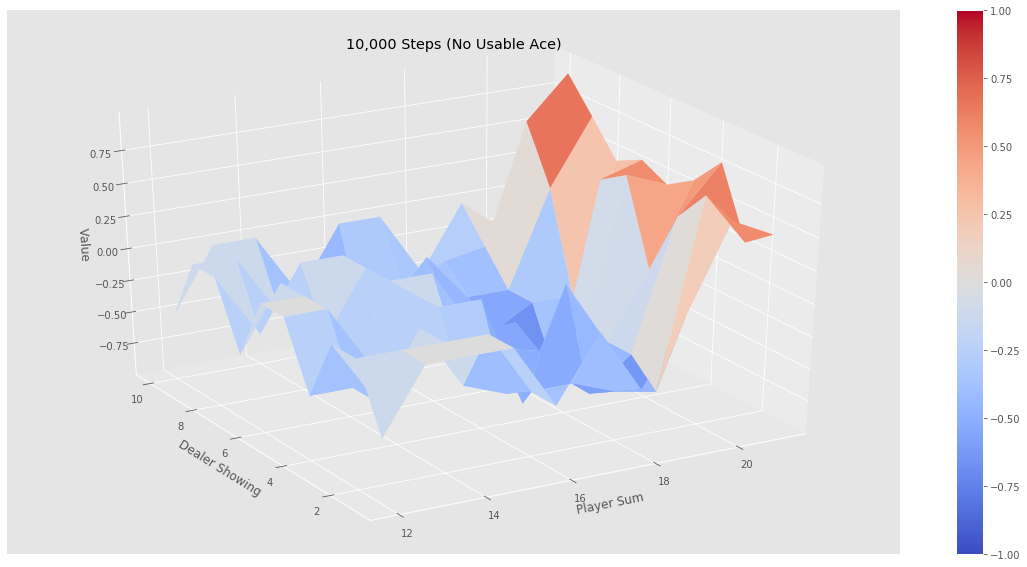

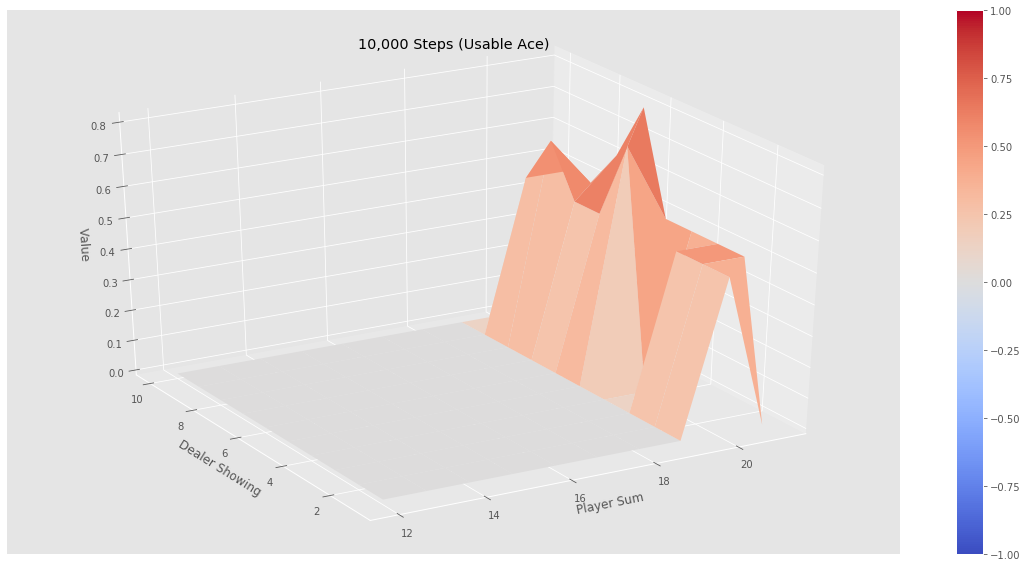

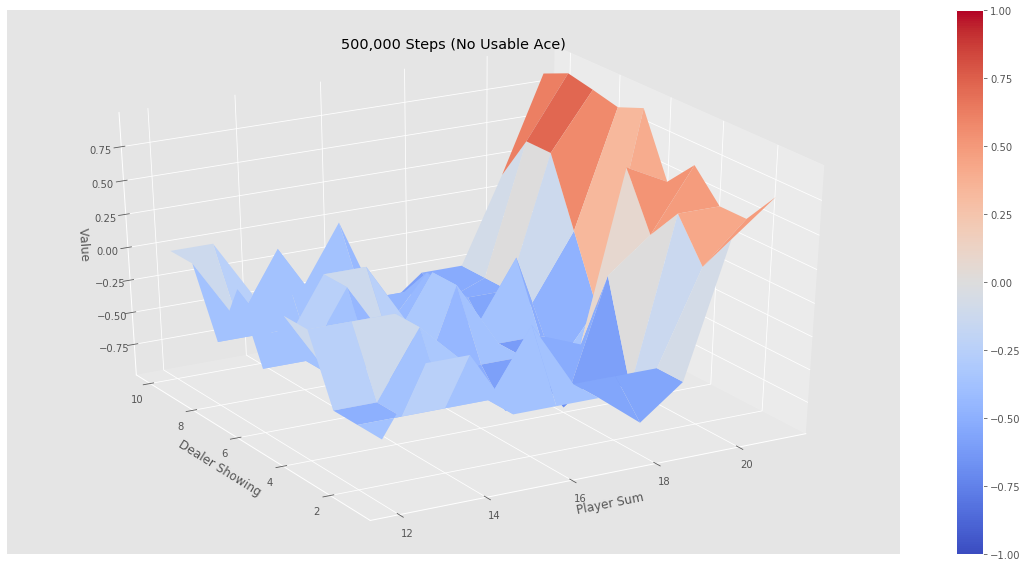

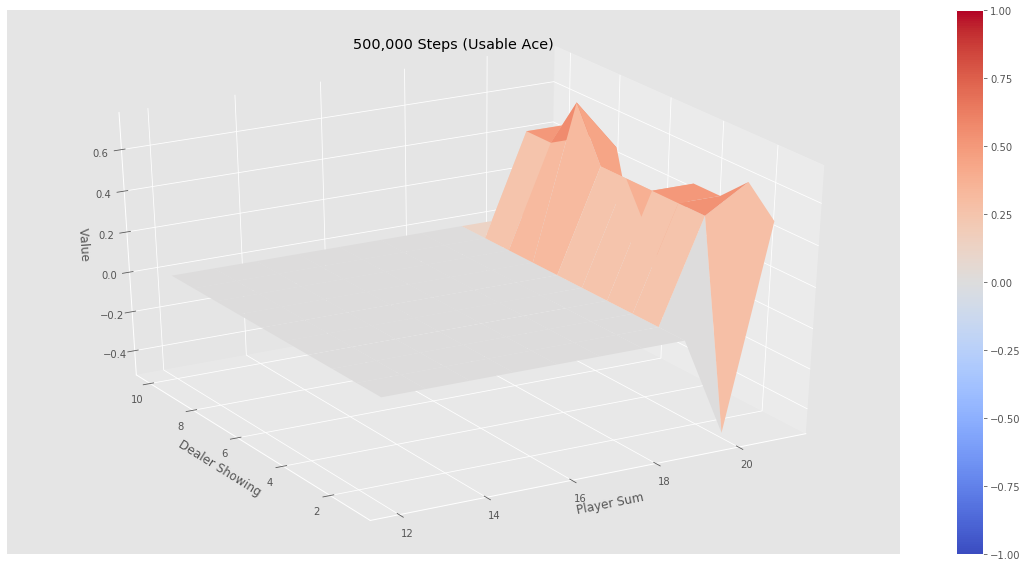

In [200]:
V_10k = mc_prediction_inc_online(sample_policy, env, num_episodes=10000,discount_factor=0.5)
plotting.plot_value_function(V_10k, title="10,000 Steps")
# 500000
V_500k = mc_prediction_inc_online(sample_policy, env, num_episodes=500000,discount_factor=0.5)
plotting.plot_value_function(V_500k, title="500,000 Steps")

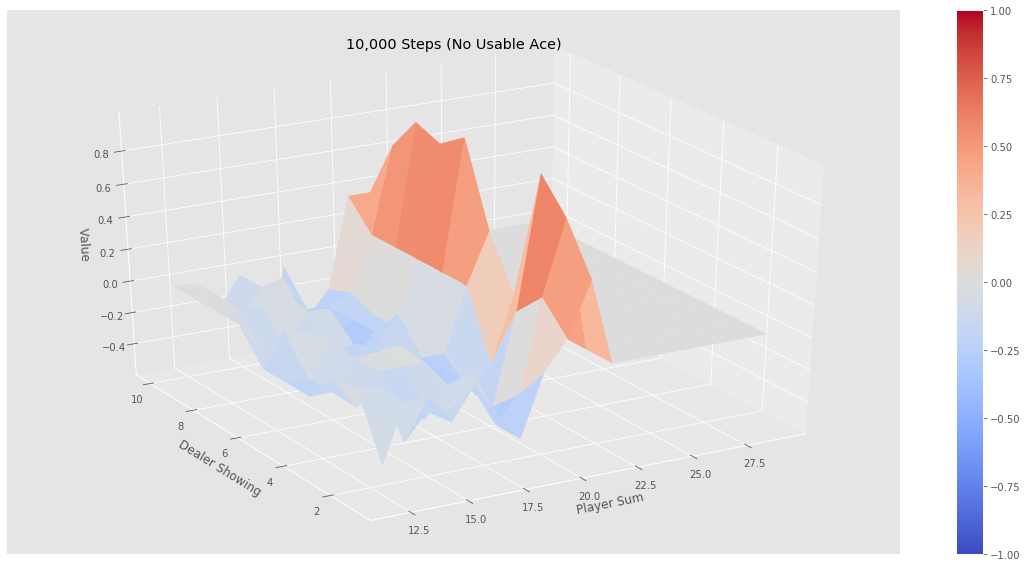

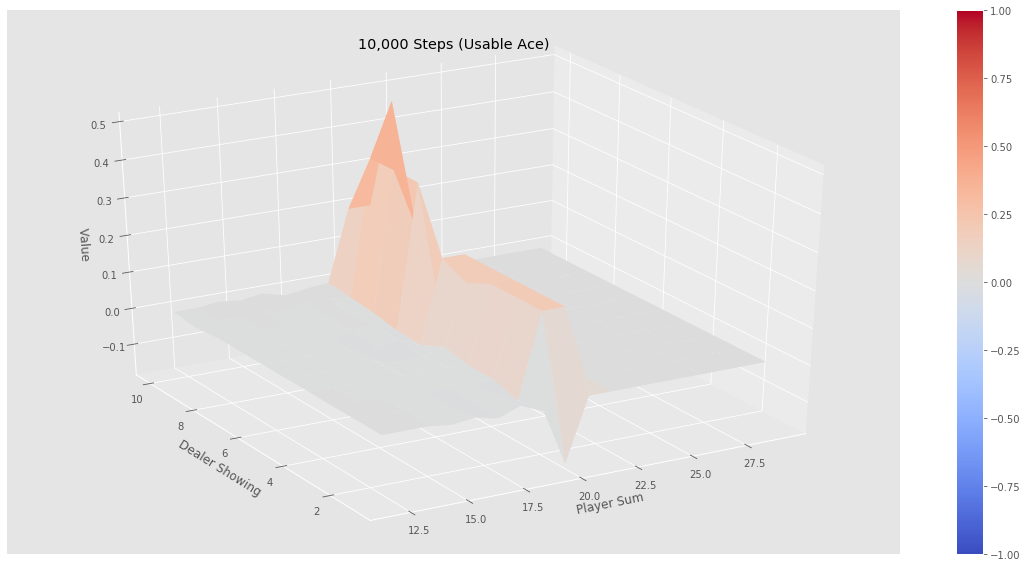

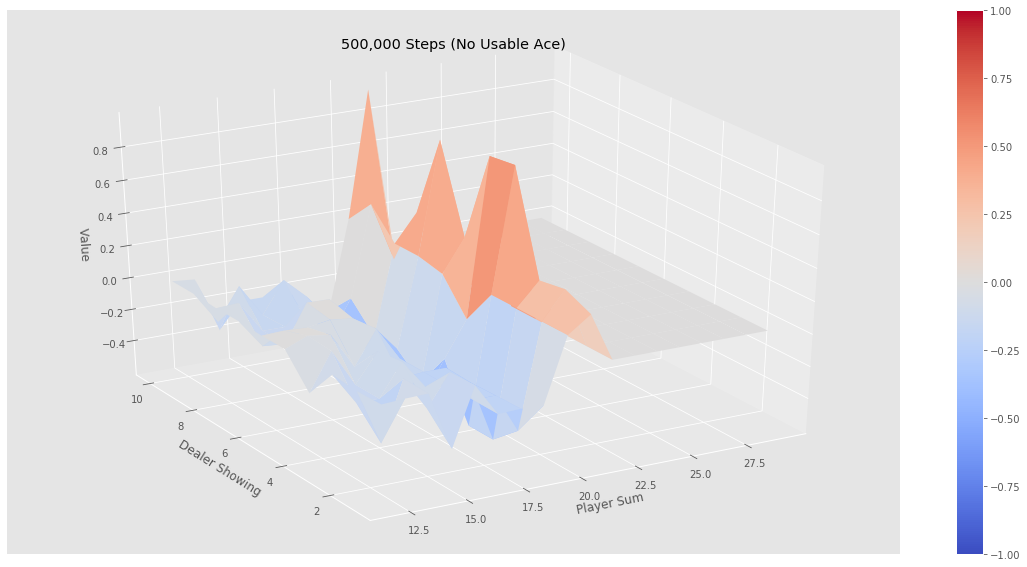

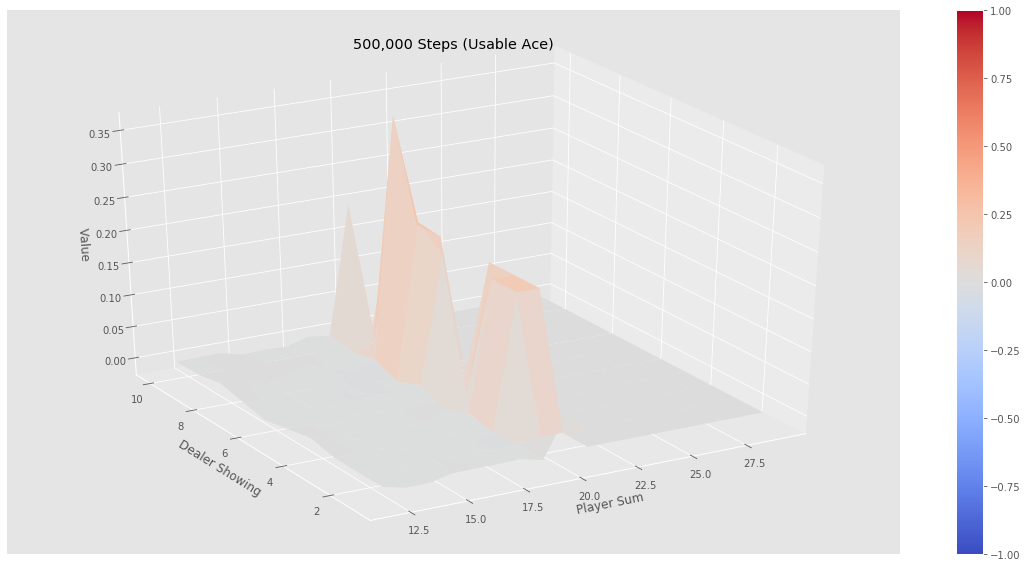

In [216]:
V_10k = TD_zero(sample_policy, env, num_episodes=10000,discount_factor=0.2)
plotting.plot_value_function(V_10k, title="10,000 Steps")
# 500000
V_500k = TD_zero(sample_policy, env, num_episodes=500000,discount_factor=0.2)
plotting.plot_value_function(V_500k, title="500,000 Steps")

In [176]:
returns_sum   = defaultdict(float)
returns_count = defaultdict(float)

# The final value function
V = defaultdict(float)
player,dealer,game_over = env.reset()

for _ in range(10):
    observation = env.reset()
    current_state_to_estimate =observation[0]

    if current_state_to_estimate in returns_count:
        returns_count[current_state_to_estimate] = returns_count[current_state_to_estimate] + 1
    else:
        returns_count[current_state_to_estimate] = 1

    action_to_take = sample_policy(observation)
    observation,reward,game_over,_ = env.step(action_to_take)

    while not game_over: 
        action_to_take = sample_policy(observation)
        observation,reward,game_over,_ = env.step(action_to_take)

    if current_state_to_estimate in returns_count:
        returns_sum[current_state_to_estimate] = returns_sum[current_state_to_estimate] + reward
    else:
        returns_sum[current_state_to_estimate] = reward

for x in returns_sum.keys():
    V[x] = returns_sum[x]/returns_count[x]

In [177]:
print(returns_sum.keys())
print(returns_count.keys())

dict_keys([15, 17, 18, 14, 19, 20, 16])
dict_keys([15, 17, 18, 14, 19, 20, 16])


In [178]:
V

defaultdict(float,
            {15: -1.0,
             17: -1.0,
             18: -1.0,
             14: -1.0,
             19: -1.0,
             20: 0.0,
             16: -1.0})

In [179]:
env.step(1)

((28, 10, False), -1, True, {})

In [180]:
for x in dir(env):
    temp = getattr(env,x)
    print(x,' : ', temp)

__class__  :  <class 'reference.lib.envs.blackjack.BlackjackEnv'>
__delattr__  :  <method-wrapper '__delattr__' of BlackjackEnv object at 0x000001B3C01B4E80>
__dict__  :  {'action_space': Discrete(2), 'observation_space': Tuple(Discrete(32), Discrete(11), Discrete(2)), 'np_random': <mtrand.RandomState object at 0x000001B3C2F1D0D8>, 'natural': False, 'dealer': [10, 7], 'player': [4, 6, 4, 9, 5], 'nA': 2}
__dir__  :  <built-in method __dir__ of BlackjackEnv object at 0x000001B3C01B4E80>
__doc__  :  Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The

In [210]:
env.reset()

(21, 7, False)

In [212]:
env.step(0)

((21, 7, False), 1, True, {})